In [1]:
# types
from numpy import array
# Imports 
import time
import datetime as dt
# Math
import pandas as pd
import numpy as np
# Plot
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
# Ml
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
# Save Models
import joblib
# Directories
from cleansting.cleansting import CleanSting
from cleansting.express import express_work_setup, rm_outliers_by_colonia, set_dummies_features, colonies_encoder, identify_skew_features
from cleansting.ml.select_model import compare_ml_models, per_error_predicts, error_resume, hpt_random_forest, hpt_ridge, hpt_linear, compare_model_error, compare_score_models
from cleansting.data_visualization.plots import heatmap_corr

In [2]:
d1 = r'C:\Users\albin\PycharmProjects\webscraper_lamudi\lamudi\json_raw\enero\lamudi_22_01_2022.json'
d2 = r'C:\Users\albin\PycharmProjects\webscraper_lamudi\lamudi\json_raw\febrero\01_02_2022.json'
d3 = r'C:\Users\albin\PycharmProjects\webscraper_lamudi\lamudi\json_raw\febrero\lamudi_15_02_22.json'
d4 = r'C:\Users\albin\PycharmProjects\webscraper_lamudi\lamudi\json_raw\marzo\lamudi_28_02_22.json'
d5 = r'C:\Users\albin\PycharmProjects\webscraper_lamudi\lamudi\json_raw\marzo\lamudi_12_03_22.json'
d6 = r'C:\Users\albin\PycharmProjects\webscraper_lamudi\lamudi\json_raw\marzo\lamudi_18_03_22.json'
d7 = r'C:\Users\albin\PycharmProjects\webscraper_lamudi\lamudi\json_raw\marzo\lamudi_26_03_2022.json'
d8 = r'C:\Users\albin\PycharmProjects\webscraper_lamudi\lamudi\json_raw\abril\lamudi_01_04_22.json'
d9 = r'C:\Users\albin\PycharmProjects\webscraper_lamudi\lamudi\json_raw\abril\lamudi_08_04_22.json'

In [3]:
cl = CleanSting()
cl.fit_json(d1, d2, d3,d4,d5,d6,d7,d8, d9)
# Clean Information and add new columns
df  =  cl.factory()
# Main Columns
columns = cl.COLUMNS

In [4]:
cl = CleanSting()
cl = cl.setup_model_data(d1, d2, d3,d4,d5,d6,d7,d8, d9, filter_by = {'tipo_inmueble': 'Casa', 'tipo_oferta': 'Venta'})

In [5]:
zona = cl.df['filtered']

In [6]:
above_50_properties = zona.colonia.value_counts().pipe(lambda serie_ : serie_[serie_ > 50]).index

In [7]:
len(above_50_properties)

33

# Test Models

In [8]:
def qualify_each_zone(data, colonies: list, **kwargs):
    
    df = data
    
    results = list()
    
    for colonie in colonies:
        
        df_colonia = df.loc[df.colonia == colonie]
        
        # Split the Data
        X = df_colonia.loc[:, columns].values
        y = df_colonia.price.values

        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 72, test_size=.30)

        model = hpt_random_forest(X_train, y_train, max_depth= [4, 6, 8])
        y_pred = model.predict(X_test)
        score_pred = model.score(X_test, y_test)


        diff = np.abs(((y_pred - y_test) / y_test) * 100)
        error_per = 100 - np.mean(diff)
        
        result = {'colonia': colonie,'score': score_pred ,'error' : np.mean(diff), 'diff_score':  error_per, 'Good': True if score_pred >= .70 else False}
        print(result, '\n')
        results.append(result)
    
    return pd.DataFrame(results)

In [9]:
result = qualify_each_zone(zona, above_50_properties)

Fitting 3 folds for each of 360 candidates, totalling 1080 fits
{'colonia': 'Valle Imperial', 'score': 0.9993466906423247, 'error': 0.4646301840361923, 'diff_score': 99.5353698159638, 'Good': True} 

Fitting 3 folds for each of 360 candidates, totalling 1080 fits
{'colonia': 'Zapopan Centro', 'score': 0.9973171742578778, 'error': 1.1021982305323776, 'diff_score': 98.89780176946762, 'Good': True} 

Fitting 3 folds for each of 360 candidates, totalling 1080 fits
{'colonia': 'Solares', 'score': 0.9945206698221875, 'error': 0.4932565970920987, 'diff_score': 99.5067434029079, 'Good': True} 

Fitting 3 folds for each of 360 candidates, totalling 1080 fits
{'colonia': 'Valle Real', 'score': 0.9976056309991523, 'error': 1.387120256131459, 'diff_score': 98.61287974386855, 'Good': True} 

Fitting 3 folds for each of 360 candidates, totalling 1080 fits
{'colonia': 'Bosques de Santa Anita', 'score': 0.9989221653405614, 'error': 0.678155628635896, 'diff_score': 99.32184437136411, 'Good': True} 

Fi

In [31]:
result.Good.sum() / len(result)

0.8787878787878788

In [33]:
result.head()

,colonia,score,error,diff_score,Good
0,Valle Imperial,0.999347,0.464630,99.535370,True
1,Zapopan Centro,0.997317,1.102198,98.897802,True
2,Solares,0.994521,0.493257,99.506743,True
3,Valle Real,0.997606,1.387120,98.612880,True
4,Bosques de Santa Anita,0.998922,0.678156,99.321844,True


In [36]:
valle_imp = zona[zona.colonia == 'Valle Imperial']

columns = [
    'm2_terreno',
           'm2_const', 'habitaciones', 'banos', 'autos',
    'endocer_colonia'
]

scaler = MinMaxScaler()

# Select Features
X = valle_imp.loc[:, columns].values
# Select Target
y = valle_imp.price.values
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 72, test_size=.30)


In [38]:
result_model = hpt_random_forest(X_train, y_train, n_estimators= [int(x) for x in np.linspace(80, 100, 4)])

Fitting 3 folds for each of 192 candidates, totalling 576 fits


In [45]:
m2_terreno = 130
m2_const= 230
habitaciones=3
banos=2
autos=2
endoder = 718
to_predict = np.array([[
    m2_terreno ,
    m2_const,  habitaciones, banos, autos,
    endoder
]])
to_predict

array([[130, 230,   3,   2,   2, 718]])

In [46]:
result_model.predict(to_predict)

array([4127400.59523809])

# General Test

In [11]:
columns = [
    'm2_terreno',
           'm2_const', 'habitaciones', 'banos', 'autos',
    'endocer_colonia'
]

scaler = MinMaxScaler()

# Select Features
X = zona.loc[:, columns].values

X_scaler = scaler.fit_transform(X)
# Select Target
y = zona.price.values
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 72, test_size=.30)

In [12]:
ridge = Ridge(alpha=99)

In [13]:
ridge = hpt_ridge(X_train, y_train, X_test, y_test)

Score: 0.7403816397362095
Best Parameters: Ridge(alpha=0)


In [14]:
lin = hpt_linear(X_train, y_train, X_test, y_test)

CV Score: 0.71
Train score 0.74
Predict Score 0.74
-----------------
All Scores 0.73


In [15]:
rf = hpt_random_forest(X_train, y_train, n_estimators= [int(x) for x in np.linspace(80, 100, 4)])

Fitting 3 folds for each of 192 candidates, totalling 576 fits


In [16]:
rf.get_params

<bound method BaseEstimator.get_params of RandomForestRegressor(max_depth=14, max_features='log2', n_estimators=93,
                      random_state=42)>

In [17]:
compare_model_error(X_test, y_test, randomfores=rf, linear=lin, ridge=ridge)


------Randomfores--------
The mean error: 37.26%
The std error: 99.37
Count Error below 7% : 0.30%

------Linear--------
The mean error: 66.28%
The std error: 125.04
Count Error below 7% : 0.13%

------Ridge--------
The mean error: 66.28%
The std error: 125.04
Count Error below 7% : 0.13%


In [18]:
compare_score_models(X_train, X_test, y_train, y_test, linear=lin, ridge=ridge, randomfores= rf)


------- Linear ---------
Train Score: 0.73
Mean Train error: 11.49% 

Test Score: 0.74
Mean Test error: 13.39%

------- Ridge ---------
Train Score: 0.73
Mean Train error: 11.49% 

Test Score: 0.74
Mean Test error: 13.39%

------- Randomfores ---------
Train Score: 0.97
Mean Train error: 12.02% 

Test Score: 0.87
Mean Test error: 22.52%

--------------------------------------
Best Model: Randomfores
Score: 87%


RandomForestRegressor(max_depth=14, max_features='log2', n_estimators=93,
                      random_state=42)

In [47]:
m2_terreno = 130
m2_const= 230
habitaciones=3
banos=2
autos=2
endoder = 718
to_predict = np.array([[
    m2_terreno ,
    m2_const,  habitaciones, banos, autos,
    endoder
]])
to_predict

array([[130, 230,   3,   2,   2, 718]])

In [48]:
r_result = rf.predict(to_predict) 
r_result

array([3128295.45617024])

In [49]:
rid_result = ridge.predict(to_predict)
rid_result

array([4745180.27676157])

In [50]:
np.mean([r_result, rid_result])

3936737.866465903

In [23]:
ridge_zona_result = ridge.predict(zona[columns].values)
rf_zona_result = rf.predict(zona[columns].values) 

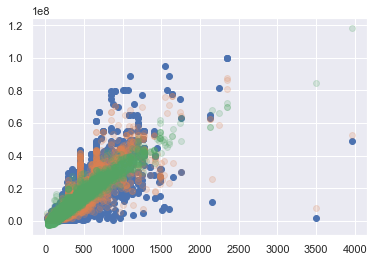

In [24]:
sns.set()
plt.scatter(x= zona.m2_const, y = zona.price )
plt.scatter(x= zona.m2_const, y = rf_zona_result, alpha= 0.2 )
plt.scatter(x= zona.m2_const, y = ridge_zona_result, alpha= 0.2 )


In [25]:
importances = pd.Series(data=rf.feature_importances_,
                        index= ['m2_terreno', 'm2_const', 'habitaciones', 'banos', 'autos', 'endocer_colonia'])


<AxesSubplot:>

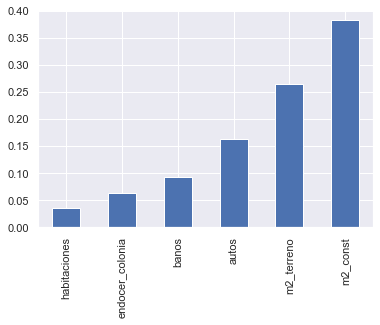

In [26]:
importances.sort_values().plot(kind='bar')